In [107]:
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform
from project.utils import collatev2
import winsound
from project.utils import compute_statistics
from project.evaluation import isa_rpn_metric, Tracker

In [108]:
t = Tracker()

In [109]:
import logging
from datetime import datetime as dtt
import os

path = 'logs'
os.makedirs(path, exist_ok=True)
os.makedirs('history', exist_ok=True)
rn = dtt.now()
dte = rn.strftime('%b_%d_%Y_%H%M%S')

logger = logging.getLogger('andy')
fh = logging.FileHandler(f'logs/{dte}.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

t.date = rn
t.logfile = f'{dte}.log'

dte

'Nov_17_2024_104536'

In [110]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
t.device = device
device

'cuda'

### Config for fitter


In [111]:
from project.model import RPN

config = {
    'model': RPN(
        input_dim=512,
        output_dim=4,
        image_size=300,
        nh=4,
        # pretrained=True
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 5,
    'loss': nn.SmoothL1Loss(),
    # 'loss': nn.MSELoss(),
    # 'loss': nn.L1Loss(),
    'lr': 0.0001
}

t.model = 'RPN'
t.model_hyperparams = config['model'].config
t.uses_resnet = config['model'].config['resnet']
t.optimizer = f"{config['optimizer']}"
t.epochs = config['epochs']
t.loss = f"{config['loss']}"
t.lr = config['lr']

324


d:\Programming Files\Python\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


#### Load Pretrained Embedder


#### Load RPN Weights


### Load dataset


In [112]:
ds = Dataset()

data = pd.read_csv('targets.csv')
data.shape

(7986, 9)

In [113]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
t.only_cmb_slices = True
data

,mri,masks,stripped,target,has_microbleed_case,has_microbleed_slice,cohort,max_value,slices
0,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,8,1,1,1,928.405273,35
1,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,9,1,1,1,928.405273,35
2,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,11,1,1,1,928.405273,35
3,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,12,1,1,1,928.405273,35
4,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,15,1,1,1,928.405273,35
...,...,...,...,...,...,...,...,...,...
359,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,25,1,1,3,241.000000,36
360,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,26,1,1,3,241.000000,36
361,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,24,1,1,3,448.000000,39
362,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,25,1,1,3,448.000000,39


### `DataLoader` Generator


In [114]:
def iqr(data, col):
    q3 = data[col].quantile(0.75)
    q1 = data[col].quantile(0.25)
    iqr = q3-q1
    new = data[(data[col] < (q3 + 1.5*iqr)) & (data[col] > (q1 - 1.5*iqr))]
    return new

In [115]:
from sklearn.model_selection import train_test_split

def make_loaders(data,
                 cohort,
                 batch_size,
                 test_size=0.2,
                 random_state=12,
                 target_shape=(300, 300),
                 rpn_mode=True,
                 logger=None,
                 tracker=t
                ):
    if cohort == 1:
        t.cohort1 = True
    if cohort == 2:
        t.cohort2 = True
    if cohort == 3:
        t.cohort3 = True
    t.batch_size = batch_size
    t.test_size = test_size
    t.target_shape = target_shape
    data = data[data.cohort == cohort]
    # data = iqr(data, 'max_value')
    
    s = f'Creating loaders for Cohort {cohort}\n'

    data_train, data_test = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state
    )

    s += f'TRAIN & TEST: {data_train.shape, data_test.shape}\n'

    paths = data_train.stripped.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )

    train_set = VALDODataset(
        cases=data_train.stripped.tolist(),
        masks=data_train.masks.tolist(),
        target=data_train.target.tolist(),
        transform=transform
    )
    val_set = VALDODataset(
        cases=data_test.stripped.tolist(),
        masks=data_test.masks.tolist(),
        target=data_test.target.tolist(),
        transform=transform
    )

    train_loader = DataLoader(
        train_set,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=collatev2
    )
    val_loader = DataLoader(
        val_set,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=collatev2
    )

    if logger != None:
        logger.info(s)
    else:
        print(s)
    
    return train_loader, val_loader, train_set, val_set

### Fitter


In [116]:
from project import Fitter

class RPNFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        evaluation_metric = {
            'iou_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': []
        }
        counter = 0
        for batch in train_loader:
            # self.log('----------------- BATCH -----------------')
            Y = []
            T = []
            for slices, masks, target, case in batch:
                # x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                x = slices.squeeze(1).float().to(self.device)
                masks = masks.squeeze(1).float().to(self.device)/300
                y = self.model(x, target)

                iou_score, precision_score, recall_score, f1_score = isa_rpn_metric(image_size=300, target_bbox=masks[target], predicted_bbox=y)
                evaluation_metric['iou_score'].append(iou_score)
                evaluation_metric['precision_score'].append(precision_score)
                evaluation_metric['recall_score'].append(recall_score)
                evaluation_metric['f1_score'].append(f1_score)
                # self.log(f'EVAL METS: {iou_score, precision_score, recall_score, f1_score}')
                Y.append(y)
                T.append(masks[target])
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += 1
            # if counter % len(batch) == 0:
            self.log(f'Batch:\t{counter}/{len(train_loader)}')
            self.log(f'Batch samples:\t{len(batch)}')
            self.log(f'Current error:\t{losses}\n')
            
            
            loss_history.append(losses.detach().cpu().numpy())
        
        self.log(f'\nTraining Evaluation Metric:')
        self.log(f"Avg IOU: {sum(evaluation_metric['iou_score']) / len(evaluation_metric['iou_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        
        return loss_history, evaluation_metric
    def validation(self, val_loader):
        self.model.eval()
        loss_history = []
        evaluation_metric = {
            'iou_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': []
        }
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    # x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(self.device)
                    x = slices.squeeze(1).float().to(self.device)
                    masks = masks.squeeze(1).float().to(self.device)/300
                    y = self.model(x, target)
                    iou_score, precision_score, recall_score, f1_score = isa_rpn_metric(image_size=300, target_bbox=masks[target], predicted_bbox=y)
                    evaluation_metric['iou_score'].append(iou_score)
                    evaluation_metric['precision_score'].append(precision_score)
                    evaluation_metric['recall_score'].append(recall_score)
                    evaluation_metric['f1_score'].append(f1_score)
                    Y.append(y)
                    T.append(masks[target])
                losses = self.loss(torch.stack(Y), torch.stack(T))
                loss_history.append(losses.cpu().numpy())
        self.log(f'\nValidation Evaluation Metric:')
        self.log(f"Avg IOU: {sum(evaluation_metric['iou_score']) / len(evaluation_metric['iou_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        return loss_history, evaluation_metric
                

In [117]:
fitter = RPNFitter(config, logger=logger)

### Train-Test Split


In [118]:
_, _, t1, v1 = make_loaders(
    data=data,
    cohort=1,
    batch_size=20
)

_, _, t3, v3 = make_loaders(
    data=data,
    cohort=3,
    batch_size=20
)

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 9), (9, 9))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)

Creating loaders for Cohort 3
TRAIN & TEST: ((37, 9), (10, 9))
Total Unique MRI Samples in data_train: 26
GLOBAL MIN & MAX (0.0, 573.0)



In [119]:
from torch.utils.data import ConcatDataset

train_set = ConcatDataset([t1, t3])
test_set = ConcatDataset([v1, v3])

In [120]:
len(train_set)

73

In [121]:
len(test_set)

19

### Training


In [122]:
from torch.utils.data import Subset
from sklearn.model_selection import KFold

In [123]:
kf = KFold(n_splits=5, shuffle=True, random_state=45)
kf

KFold(n_splits=5, random_state=45, shuffle=True)

In [124]:
fold_metrics = []
rpn_kfold_dir = f'./rpn_kfold/{dte}'
os.makedirs(rpn_kfold_dir, exist_ok=True)

for i, (train_index, val_index) in enumerate(kf.split(train_set)):
    print(f'Fold {i + 1}/{5}')
    
    config['model'] = RPN(
        input_dim=512,
        output_dim=4,
        image_size=300,
        nh=4,
    ).to(device)
    
    fitter = RPNFitter(config, logger=logger)
    
    train_subset = Subset(train_set, train_index)
    val_subset = Subset(train_set, val_index)
    
    train_subset_dl = DataLoader(
        train_subset,
        shuffle=True,
        batch_size=20,
        collate_fn=collatev2
    )
    
    val_subset_dl = DataLoader(
        val_subset,
        shuffle=True,
        batch_size=20,
        collate_fn=collatev2
    )
    
    thist, vhist, tmhist, vmhist = fitter.fit(train_subset_dl, val_subset_dl)
    
    fold_metrics.append({
        'fold': i + 1,
        'training_history': thist,
        'validation_history': vhist,
        'training_metrics': tmhist,
        'validation_metrics': vmhist
    })
    
    torch.save(fitter.model.state_dict(), f'{rpn_kfold_dir}/RPN_{dte}_fold_{i+1}.pt')

    

d:\Programming Files\Python\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:andy:EPOCH 0 ==============================


Fold 1/5
324


INFO:andy:Batch:	1/3
INFO:andy:Batch samples:	20
INFO:andy:Current error:	0.01666484959423542

INFO:andy:Batch:	2/3
INFO:andy:Batch samples:	20
INFO:andy:Current error:	0.01607472635805607

INFO:andy:Batch:	3/3
INFO:andy:Batch samples:	18
INFO:andy:Current error:	0.015667786821722984

INFO:andy:
Training Evaluation Metric:
INFO:andy:Avg IOU: 0.16067088051329784
INFO:andy:Avg Precision: 0.37718253813940905
INFO:andy:Avg Recall: 0.25392052004161964
INFO:andy:Avg F1: 0.24461817992690565
INFO:andy:
Validation Evaluation Metric:
INFO:andy:Avg IOU: 0.30635905812184017
INFO:andy:Avg Precision: 0.40273240953683853
INFO:andy:Avg Recall: 0.6249932497739792
INFO:andy:Avg F1: 0.4419390549262365
INFO:andy:EPOCH 1 ==============================
INFO:andy:Batch:	1/3
INFO:andy:Batch samples:	20
INFO:andy:Current error:	0.011738146655261517

INFO:andy:Batch:	2/3
INFO:andy:Batch samples:	20
INFO:andy:Current error:	0.01730279251933098

INFO:andy:Batch:	3/3
INFO:andy:Batch samples:	18
INFO:andy:Current e

Fold 2/5
324


INFO:andy:Batch:	1/3
INFO:andy:Batch samples:	20
INFO:andy:Current error:	0.04044049605727196

INFO:andy:Batch:	2/3
INFO:andy:Batch samples:	20
INFO:andy:Current error:	0.020955581218004227

INFO:andy:Batch:	3/3
INFO:andy:Batch samples:	18
INFO:andy:Current error:	0.015157514251768589

INFO:andy:
Training Evaluation Metric:
INFO:andy:Avg IOU: 0.07891540457333984
INFO:andy:Avg Precision: 0.277870063637865
INFO:andy:Avg Recall: 0.10841169535856822
INFO:andy:Avg F1: 0.12373889558788004
INFO:andy:
Validation Evaluation Metric:
INFO:andy:Avg IOU: 0.25450626326104003
INFO:andy:Avg Precision: 0.2923618762443463
INFO:andy:Avg Recall: 0.6262660324573517
INFO:andy:Avg F1: 0.37925688351194065
INFO:andy:EPOCH 1 ==============================
INFO:andy:Batch:	1/3
INFO:andy:Batch samples:	20
INFO:andy:Current error:	0.011357891373336315

INFO:andy:Batch:	2/3
INFO:andy:Batch samples:	20
INFO:andy:Current error:	0.01368112862110138

INFO:andy:Batch:	3/3
INFO:andy:Batch samples:	18
INFO:andy:Current er

Fold 3/5
324


INFO:andy:Batch:	1/3
INFO:andy:Batch samples:	20
INFO:andy:Current error:	0.03691547363996506

INFO:andy:Batch:	2/3
INFO:andy:Batch samples:	20
INFO:andy:Current error:	0.013075518421828747

INFO:andy:Batch:	3/3
INFO:andy:Batch samples:	18
INFO:andy:Current error:	0.015646381303668022

INFO:andy:
Training Evaluation Metric:
INFO:andy:Avg IOU: 0.13177059091033477
INFO:andy:Avg Precision: 0.2796390341466357
INFO:andy:Avg Recall: 0.19763329425617923
INFO:andy:Avg F1: 0.20090100284794282
INFO:andy:
Validation Evaluation Metric:
INFO:andy:Avg IOU: 0.26078747113545736
INFO:andy:Avg Precision: 0.5546878904104233
INFO:andy:Avg Recall: 0.39372831185658774
INFO:andy:Avg F1: 0.40329591631889344
INFO:andy:EPOCH 1 ==============================
INFO:andy:Batch:	1/3
INFO:andy:Batch samples:	20
INFO:andy:Current error:	0.012868580408394337

INFO:andy:Batch:	2/3
INFO:andy:Batch samples:	20
INFO:andy:Current error:	0.014916305430233479

INFO:andy:Batch:	3/3
INFO:andy:Batch samples:	18
INFO:andy:Current

Fold 4/5
324


INFO:andy:EPOCH 0 ==============================
INFO:andy:Batch:	1/3
INFO:andy:Batch samples:	20
INFO:andy:Current error:	0.04471707344055176

INFO:andy:Batch:	2/3
INFO:andy:Batch samples:	20
INFO:andy:Current error:	0.02009844034910202

INFO:andy:Batch:	3/3
INFO:andy:Batch samples:	19
INFO:andy:Current error:	0.013881291262805462

INFO:andy:
Training Evaluation Metric:
INFO:andy:Avg IOU: 0.07990120938767963
INFO:andy:Avg Precision: 0.21774150044420512
INFO:andy:Avg Recall: 0.13426203889943958
INFO:andy:Avg F1: 0.12464216375778729
INFO:andy:
Validation Evaluation Metric:
INFO:andy:Avg IOU: 0.26999033535165445
INFO:andy:Avg Precision: 0.4187152912574155
INFO:andy:Avg Recall: 0.5175585885133062
INFO:andy:Avg F1: 0.3904824954058443
INFO:andy:EPOCH 1 ==============================
INFO:andy:Batch:	1/3
INFO:andy:Batch samples:	20
INFO:andy:Current error:	0.012174814939498901

INFO:andy:Batch:	2/3
INFO:andy:Batch samples:	20
INFO:andy:Current error:	0.014620778150856495

INFO:andy:Batch:	3/

Fold 5/5
324


INFO:andy:Batch:	1/3
INFO:andy:Batch samples:	20
INFO:andy:Current error:	0.0422423891723156

INFO:andy:Batch:	2/3
INFO:andy:Batch samples:	20
INFO:andy:Current error:	0.021898413076996803

INFO:andy:Batch:	3/3
INFO:andy:Batch samples:	19
INFO:andy:Current error:	0.017996208742260933

INFO:andy:
Training Evaluation Metric:
INFO:andy:Avg IOU: 0.07786928828000643
INFO:andy:Avg Precision: 0.27004834333971395
INFO:andy:Avg Recall: 0.10295475930196502
INFO:andy:Avg F1: 0.12306285265170164
INFO:andy:
Validation Evaluation Metric:
INFO:andy:Avg IOU: 0.2617091044251408
INFO:andy:Avg Precision: 0.27916285608495983
INFO:andy:Avg Recall: 0.6725417231874806
INFO:andy:Avg F1: 0.3785614850265639
INFO:andy:EPOCH 1 ==============================
INFO:andy:Batch:	1/3
INFO:andy:Batch samples:	20
INFO:andy:Current error:	0.014936658553779125

INFO:andy:Batch:	2/3
INFO:andy:Batch samples:	20
INFO:andy:Current error:	0.015473625622689724

INFO:andy:Batch:	3/3
INFO:andy:Batch samples:	19
INFO:andy:Current e

In [125]:
winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

In [126]:
import numpy as np 
[np.array(fold).mean() for fold in fold_metrics[i]['training_history']]

[0.027379004, 0.016506338, 0.017812664, 0.016746854, 0.012918342]

In [127]:
fold_metrics[0]

thist_array = []
vhist_array = []
v_iou_array = []
v_precision_array = []
v_recall_array = []
v_f1score_array = []


def get_avg_score(set, metric):
    return np.array(fold_metrics[i][set][0][metric]).mean()

for i in range(5):
    print(f'K-Fold {i+1}')
    
    thist = [np.array(fold).mean() for fold in fold_metrics[i]['training_history']]
    print(f'Training History: {thist}')
    thist_array.append(thist)
    
    vhist = [np.array(fold).mean() for fold in fold_metrics[i]['validation_history']]
    print(f'Validation History: {vhist}')
    vhist_array.append(vhist)
    
    # print('\nTraining Metrics')
    # print(f"Average IOU: {get_avg_score('training_metrics', 'iou_score')}")
    # print(f"Average Precision: {get_avg_score('training_metrics', 'precision_score')}")
    # print(f"Average Recall: {get_avg_score('training_metrics', 'recall_score')}")
    # print(f"Average F1 Score: {get_avg_score('training_metrics', 'f1_score')}")
    
    print(f'\nFold {i+1}: Validation Metrics')
    v_iou = get_avg_score('validation_metrics', 'iou_score')
    print(f"Average IOU: {v_iou}")
    v_iou_array.append(v_iou)
    
    v_precision = get_avg_score('validation_metrics', 'precision_score')
    print(f"Average Precision: {v_precision}")
    v_precision_array.append(v_precision)
    
    v_recall = get_avg_score('validation_metrics', 'recall_score')
    print(f"Average Recall: {v_recall}")
    v_recall_array.append(v_recall)
    
    v_f1 = get_avg_score('validation_metrics', 'f1_score')
    print(f"Average F1 Score: {v_f1}")
    v_f1score_array.append(v_f1)
    
    print('\n===================================\n')

K-Fold 1
Training History: [0.016135788, 0.013983138, 0.013513509, 0.011899054, 0.010680939]
Validation History: [0.012262058, 0.013184466, 0.011330217, 0.0100223925, 0.008149845]

Fold 1: Validation Metrics
Average IOU: 0.30635905812184017
Average Precision: 0.40273240953683853
Average Recall: 0.6249932497739792
Average F1 Score: 0.4419390549262365


K-Fold 2
Training History: [0.025517864, 0.014160819, 0.01669951, 0.013873515, 0.009583703]
Validation History: [0.015629882, 0.02258298, 0.020208647, 0.014017255, 0.01089708]

Fold 2: Validation Metrics
Average IOU: 0.25450626326104003
Average Precision: 0.2923618762443463
Average Recall: 0.6262660324573517
Average F1 Score: 0.37925688351194065


K-Fold 3
Training History: [0.021879124, 0.014438589, 0.014087913, 0.012126751, 0.010346948]
Validation History: [0.010955221, 0.013122456, 0.0127066225, 0.0118447505, 0.014505245]

Fold 3: Validation Metrics
Average IOU: 0.26078747113545736
Average Precision: 0.5546878904104233
Average Recall: 

In [128]:
print('K-Fold Cross Validation: Validation Metrics')
print(f'Average IOU: {np.array(v_iou_array).mean()} ')
print(f'Average Precision: {np.array(v_precision_array).mean()} ')
print(f'Average Recall: {np.array(v_recall_array).mean()} ')
print(f'Average F1 Score: {np.array(v_f1score_array).mean()} ')

K-Fold Cross Validation: Validation Metrics
Average IOU: 0.27067044645902655 
Average Precision: 0.3895320647067967 
Average Recall: 0.567017581157741 
Average F1 Score: 0.39870716703789577 


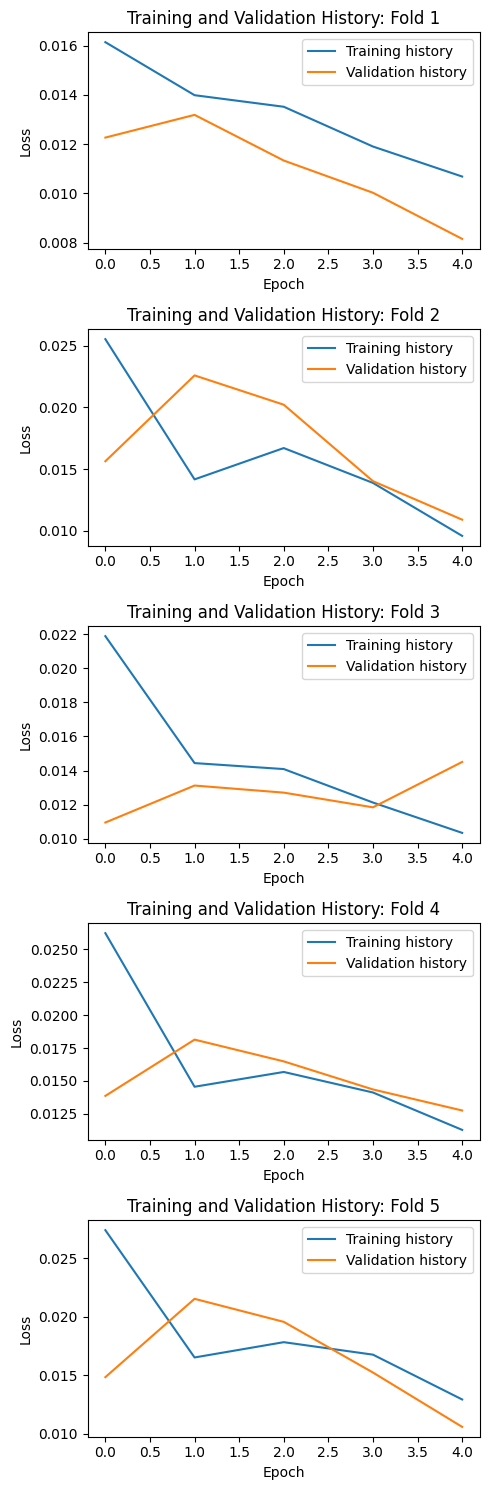

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5,1, figsize=(5, 15))

for i in range(5):
    th = np.array(thist_array[i])
    vh = np.array(vhist_array[i])
    
    ax=axes[i]
    
    sns.lineplot(th, label='Training history', ax=ax)
    sns.lineplot(vh, label='Validation history', ax=ax)
    
    ax.set_title(f'Training and Validation History: Fold {i+1}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
  
plt.tight_layout()  
plt.show()

In [130]:
len(test_set)

19

### Quick Note


All the lost history of the folds are provided here. Future fix here if we only want the best fold, but take note that the current approach is just manually selecting the best fold.


In [131]:
sth = f'history/{dte}_thist.pt'
svh = f'history/{dte}_vhist.pt'
t.saved_thist = sth
t.saved_vhist = svh
torch.save(thist_array, sth)
torch.save(vhist_array, svh)

### Evaluation


In [132]:
test_dataloader = DataLoader(
    test_set,
    shuffle=True,
    batch_size=20,
    collate_fn=collatev2
)

In [136]:
test_iou = []
test_precision = []
test_recall = []
test_f1 = []

for filename in os.listdir(rpn_kfold_dir):
    fitter.model.load_state_dict(torch.load(f'{rpn_kfold_dir}/{filename}'))
    
    h, mh = fitter.validation(test_dataloader)
    valmets = pd.DataFrame(mh)
    mets = valmets.mean()
    
    print(f'Version {filename}:')
    
    test_iou.append(mets.iou_score)
    test_precision.append(mets.precision_score)
    test_recall.append(mets.recall_score)
    test_f1.append(mets.f1_score)
    
    print('\n========================\n')

INFO:andy:
Validation Evaluation Metric:
INFO:andy:Avg IOU: 0.23639957293083794
INFO:andy:Avg Precision: 0.4150950163602829
INFO:andy:Avg Recall: 0.36123943799420405
INFO:andy:Avg F1: 0.3510229289531708


Version RPN_Nov_17_2024_104536_fold_1.pt:




INFO:andy:
Validation Evaluation Metric:
INFO:andy:Avg IOU: 0.24241460546066887
INFO:andy:Avg Precision: 0.3985831894372639
INFO:andy:Avg Recall: 0.3907321636614047
INFO:andy:Avg F1: 0.3670808249398282


Version RPN_Nov_17_2024_104536_fold_2.pt:




INFO:andy:
Validation Evaluation Metric:
INFO:andy:Avg IOU: 0.222363344516213
INFO:andy:Avg Precision: 0.3998186208895947
INFO:andy:Avg Recall: 0.3191155096466996
INFO:andy:Avg F1: 0.3208311880497556


Version RPN_Nov_17_2024_104536_fold_3.pt:




INFO:andy:
Validation Evaluation Metric:
INFO:andy:Avg IOU: 0.27802266452559515
INFO:andy:Avg Precision: 0.45830207876861095
INFO:andy:Avg Recall: 0.45532621516797106
INFO:andy:Avg F1: 0.4079329819467507


Version RPN_Nov_17_2024_104536_fold_4.pt:




INFO:andy:
Validation Evaluation Metric:
INFO:andy:Avg IOU: 0.24954029055018173
INFO:andy:Avg Precision: 0.3447724110201785
INFO:andy:Avg Recall: 0.4672264095984007
INFO:andy:Avg F1: 0.3749245993400875


Version RPN_Nov_17_2024_104536_fold_5.pt:




In [137]:
iou_score = np.array(test_iou).mean()
precision_score = np.array(test_precision).mean()
recall_score = np.array(test_recall).mean()
f1_score = np.array(test_f1).mean()

In [138]:
print('Test Set Performance Metrics')
print(f'Average IOU: {iou_score} ')
print(f'Average Precision: {precision_score} ')
print(f'Average Recall: {recall_score} ')
print(f'Average F1 Score: {f1_score} ')

Test Set Performance Metrics
Average IOU: 0.24574809559669936 
Average Precision: 0.4033142632951862 
Average Recall: 0.39872794721373606 
Average F1 Score: 0.36435850464591857 


In [ ]:
t.iou = iou_score
t.precision = precision_score
t.recall = recall_score
t.f1 = f1_score

### Save the weights


In [139]:
s = [file for file in os.listdir(rpn_kfold_dir)]
s

['RPN_Nov_17_2024_104536_fold_1.pt',
 'RPN_Nov_17_2024_104536_fold_2.pt',
 'RPN_Nov_17_2024_104536_fold_3.pt',
 'RPN_Nov_17_2024_104536_fold_4.pt',
 'RPN_Nov_17_2024_104536_fold_5.pt']

In [140]:
t.saved_weights = s
# torch.save(model.state_dict(), s)

# Trial


In [141]:
model = fitter.model

In [142]:
sample = next(enumerate(test_dataloader))

In [143]:
slices, masks, target, case = sample[1][1]

In [144]:
# x = slices.squeeze(1).repeat(1, 3, 1, 1).float().to(device)
x = slices.squeeze(1).float().to(device)
T = masks.squeeze(1).float().to(device)

In [145]:
y = model(x, target)

In [146]:
y

tensor([[0.1802, 0.2900, 0.4334, 0.7930]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [147]:
fitter.loss(y, T[target])

tensor(120.3649, device='cuda:0', grad_fn=<SmoothL1LossBackward0>)

In [148]:
masks[target]

tensor([[[  5.8594, 116.0156, 126.5625, 236.7188]]], dtype=torch.float64)

In [149]:
y

tensor([[0.1802, 0.2900, 0.4334, 0.7930]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [150]:
bbox = masks[target].squeeze().cpu().long()

In [151]:
y = (y*300).squeeze().detach().cpu().long()

In [152]:
bbox, y

(tensor([  5, 116, 126, 236]), tensor([ 54,  87, 130, 237]))

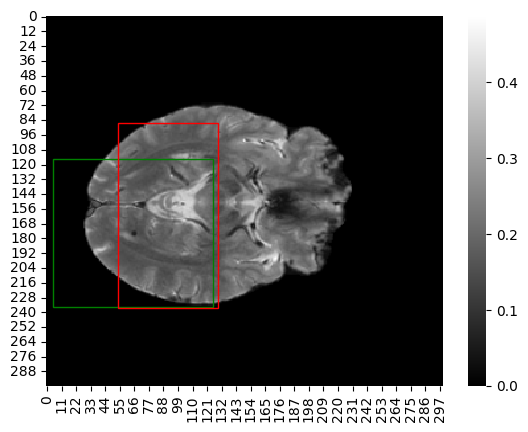

In [153]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

ax = sns.heatmap(x[target][0].squeeze().cpu(), cmap='gray')

truth = patches.Rectangle(
    (bbox[0], bbox[1]),
    bbox[2] - bbox[0],
    bbox[3] - bbox[1],
    linewidth=1, edgecolor='g', facecolor='none'
)

pred = patches.Rectangle(
    (y[0], y[1]),
    y[2] - y[0],
    y[3] - y[1],
    linewidth=1, edgecolor='r', facecolor='none'
)

ax.add_patch(truth)
ax.add_patch(pred)
plt.show()

# Log Progress


In [154]:
t.notes = '''
- applied 5 kfold cross validation
- fixed the reinitialization issue of the fitter
- save weights of each fold
- evaluate test data using each fold
- need to imrpove this by implementing end to end in one notebook (rpn and vit)
'''

In [155]:
t()

,model,loaded_weights,stage1_weights,uses_resnet,only_cmb_slices,cohort1,cohort2,cohort3,optimizer,epochs,...,recall,f1,fpr,saved_weights,saved_thist,saved_vhist,model_hyperparams,logfile,device,notes
date,,,,,,,,,,,,,,,,,,,,,
2024-11-17 10:45:36.060088,RPN,None,None,False,True,True,False,True,<class 'torch.optim.adam.Adam'>,5,...,None,None,None,"[RPN_Nov_17_2024_104536_fold_1.pt, RPN_Nov_17_...",history/Nov_17_2024_104536_thist.pt,history/Nov_17_2024_104536_vhist.pt,"{'input_dim': 512, 'output_dim': 4, 'image_siz...",Nov_17_2024_104536.log,cuda,\n- applied 5 kfold cross validation\n- fixed ...


In [156]:
if os.path.exists('history/runs.csv'):
    print('Merging to old df')
    prev_df = pd.read_csv('history/runs.csv', index_col='date')
    merged = pd.concat([prev_df, t()])
    merged.to_csv('history/runs.csv')
else:
    print('Making new csv file')
    t().to_csv('history/runs.csv')

Making new csv file
